In [2]:
import torch
import os
import json
import sys
import pandapower as pp
import numpy as np
import julia
from torch.utils.data import DataLoader, TensorDataset
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

sys.path.append(os.path.abspath('../entrenamiento'))


from omegaconf import OmegaConf
from find_best_run import find_best_run
from src.arquitecturas import GNNUnsupervised
from src.Data_loader import load_net, load_data
from src.utils import get_Ybus, get_Yline, init_lamdas
from src.Loss import my_loss, get_max_min_values



import warnings
warnings.filterwarnings('ignore')


red = "30"

dt =  find_best_run(f"./runs/{red}/")[0][0]
print(dt)
cfg = OmegaConf.load(f"./runs/{red}/" + dt + "/config.yaml")
weights_dir = f"./runs/{red}/" + dt +  "/weights/best_model.pt"

# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
edge_index, edge_weights, net = load_net(cfg.data.red,cfg.data.red_path,device)
pp.runpp(net)
Y_bus = get_Ybus(net,device)
min_vector, max_vector = get_max_min_values(net,device)

if red == "30":
    net.line["max_loading_percent"] *= 1.1
else:
    net.trafo.tap_pos = 0.0

# Set model
num_layers = len(cfg.model.layers) - 1
num_nodes = len(net.bus)
model = GNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,batch_norm=cfg.training.batch_norm).to(device)

# Load data
# train_loader, val_loader, test_loader = load_data(cfg.data.data_path, cfg.training.batch_size, False, cfg.data.red,device)
# train_loader_norm, val_loader_norm, test_loader_norm = load_data(cfg.data.data_path, cfg.training.batch_size, True, cfg.data.red,device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model.load_state_dict(torch.load(weights_dir))

[ Info: Julia version info


Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      "Manjaro Linux"
  uname: Linux 6.6.30-2-MANJARO #1 SMP PREEMPT_DYNAMIC Wed May  8 17:46:43 UTC 2024 x86_64 unknown
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4264 MHz     605166 s        106 s      85280 s   13471035 s       6939 s
       
  Memory: 62.63358688354492 GB (12330.41796875 MB free)
  Uptime: 88819.0 sec
  Load Avg:  1.88  1.77  1.88
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, goldmont)
Environment:
  HOME = /home/iboero
  PATH = /home/iboero/miniconda3/envs/proy/bin:/home/iboero/.vscode-server/bin/863d2581ecda6849923a2118d93a088b0745d9d6/bin/remote-cli:/home/iboero/miniconda3/envs/proy/bin:/home/iboero/miniconda3/condabin:/home/iboero/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsight_compute:/opt/cuda

[ Info: Julia executable: /home/iboero/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
│     libpython: /home/iboero/miniconda3/envs/proy/lib/libpython3.11.so.1.0
│ Python:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
└     libpython: 


05-29_22:00:07


<All keys matched successfully>

In [10]:
X_tensor_test = (torch.Tensor(np.load(f'/home/iboero/Tesis/unsupervised_ieee/GNN4OPF/data/red{red}/test/input.npy') ) / 100).to(device)
y_tensor_test = torch.Tensor(np.load(f'/home/iboero/Tesis/unsupervised_ieee/GNN4OPF/data/red{red}/test/vm_pu_opt.npy')).to(device)
data_test = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(data_test, batch_size=cfg.training.batch_size)

y_pred = []
x_tot = []
y_tot = []
for input,y in test_loader:
    y_pred.append(model(input).detach().cpu().numpy())
    x_tot.append(input.detach().cpu().numpy())
    y_tot.append(y.detach().cpu().numpy())

# Concatenate in dim 0
y_pred = np.concatenate(y_pred, axis=0)
y_pred = y_pred[:,:,2][:,:,None]
x_tot = np.concatenate(x_tot, axis=0)
y_tot = np.concatenate(y_tot, axis=0)
y_tot = y_tot[:,:,None]


In [16]:
y_tot[100]

array([[0.       ],
       [1.0024836],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0196123],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0231758],
       [1.0162424],
       [0.       ],
       [0.       ],
       [0.       ],
       [1.0183221],
       [0.       ],
       [0.       ],
       [0.       ]], dtype=float32)

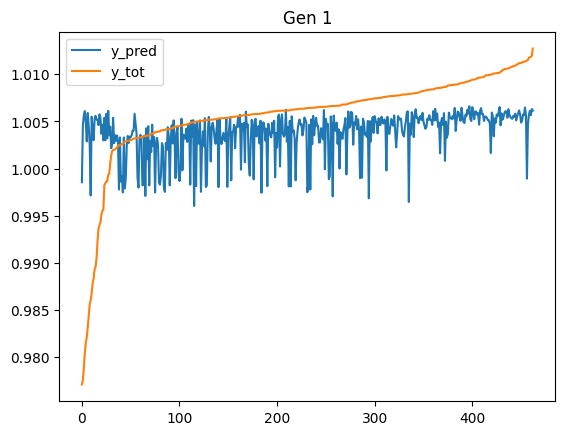

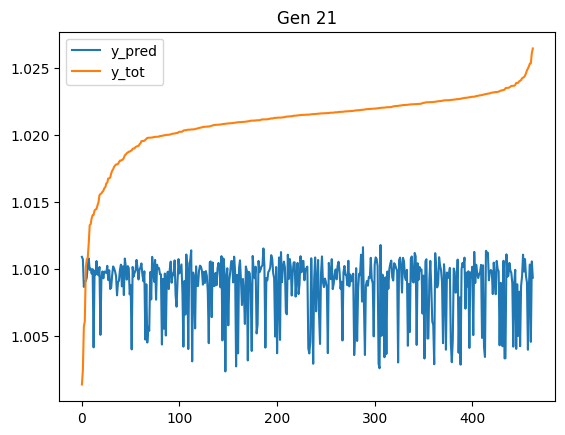

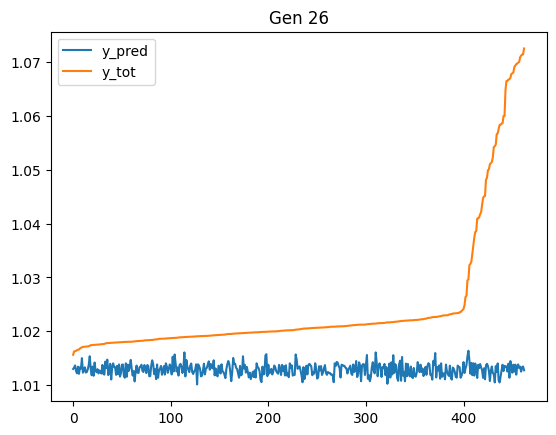

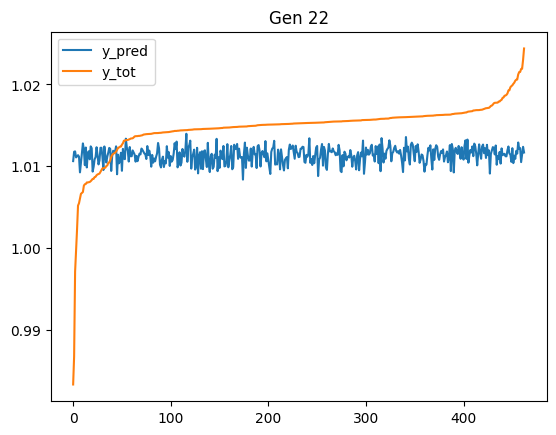

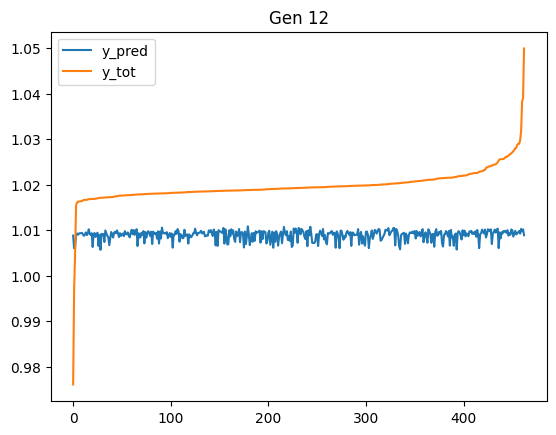

In [11]:
import matplotlib.pyplot as plt

idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
# Plot an histagram per gen of y_pred and y_tot
for i in idx_gens:
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot[:,i].squeeze())
    y_tot_i = y_tot[idx,i].squeeze()
    y_pred_i = y_pred[idx,i].squeeze()
    
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Gen {i}")
    plt.legend()
    plt.show()

In [5]:
x_tot.shape

(463, 30, 3)

In [6]:
y_tot.shape

(463, 30, 1)

In [7]:
y_pred.shape

(463, 30, 1)

Da diferente, puede ser que el modelo unsup saque otra salida que tambien es valida. Ver de comparar la feasibility y el vm_pu metric para ambos casos, o alguna otra forma de ver cual solucion da mejor.

In [20]:
def get_stats(net):
    v_cost = np.abs(net.res_bus.vm_pu.values - 1).sum()
    unfeas_line = (net.res_line.loading_percent.values > 1.05*net.line.max_loading_percent.values).sum()
    unfeas_trafo = 0
    # unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values).sum()
    unfeas_volt = (net.res_bus.vm_pu.values < 0.99*net.bus.min_vm_pu.values).sum() + (net.res_bus.vm_pu.values > 1.01*net.bus.max_vm_pu.values).sum()

    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0:
        unfeas = True
    else:
        unfeas = False
    return v_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt]

v_cost_hist = []
unf_hist = []
unf_cont_hist = []

for idx in range(np.shape(x_tot)[0]):
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0] * 100
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]* 100
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]* 100

    net.gen.vm_pu = y_pred[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_pred, unf_pred, unf_const_pred = get_stats(net)

    net.gen.vm_pu = 1
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1  = get_stats(net)
    
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt  = get_stats(net)
    
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])


v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

In [21]:
x_tot[0]

array([[0.        , 0.        , 0.        ],
       [0.21866418, 0.16504912, 0.48010918],
       [0.01786963, 0.01515363, 0.        ],
       [0.09808126, 0.01421919, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.16718513, 0.13440828, 0.        ],
       [0.26327184, 0.337171  , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.0716696 , 0.01961285, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.12081007, 0.09413846, 0.        ],
       [0.        , 0.        , 0.13105263],
       [0.07701112, 0.01855571, 0.        ],
       [0.09923077, 0.03142805, 0.        ],
       [0.02954951, 0.01944382, 0.        ],
       [0.1010123 , 0.06036343, 0.        ],
       [0.02342014, 0.00879381, 0.        ],
       [0.08504982, 0.03607686, 0.        ],
       [0.01957974, 0.00829466, 0.        ],
       [0.18831812, 0.08982975, 0.        ],
       [0.        , 0.        , 0.21374056],
       [0.

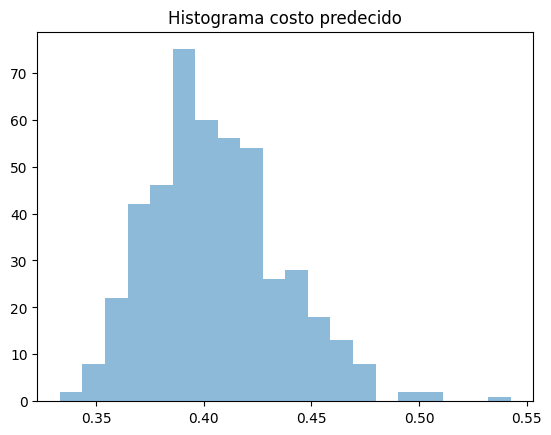

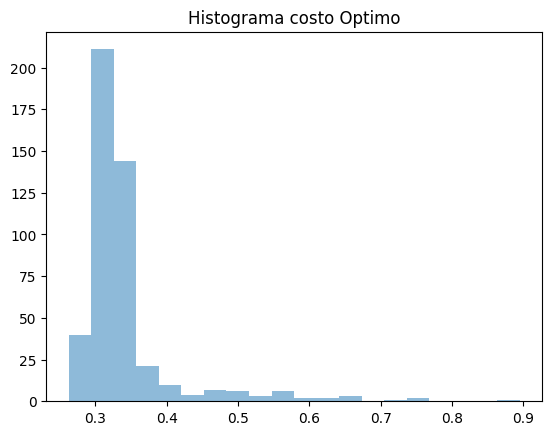

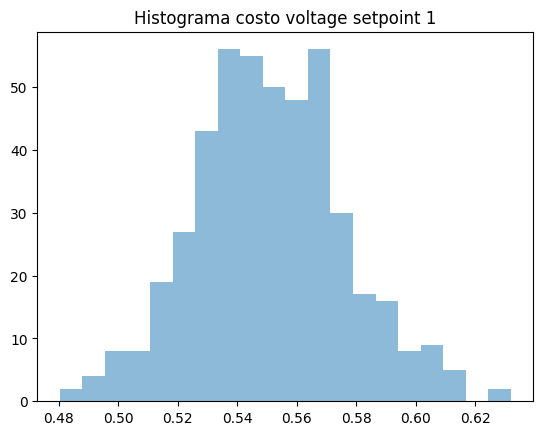

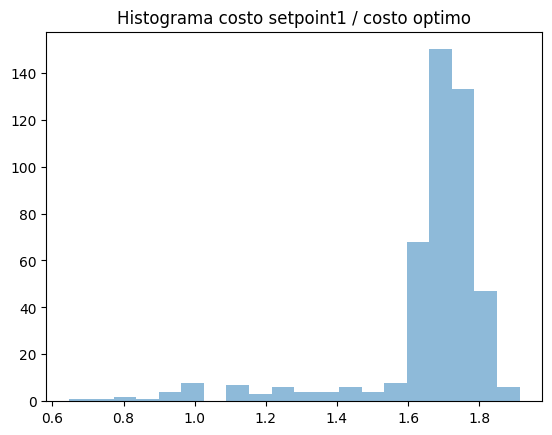

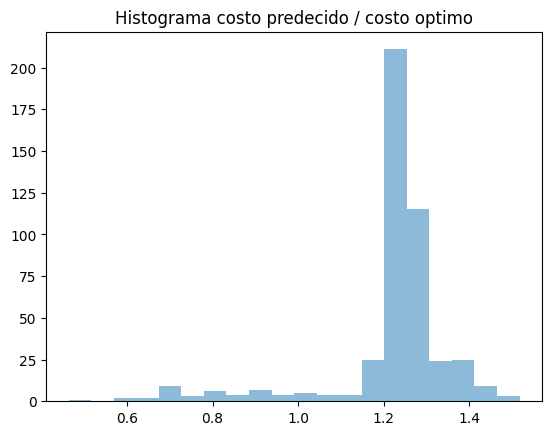

In [22]:
# Histogram of columns of v_cost_hist

plt.title("Histograma costo predecido")
plt.hist(v_cost_hist[:,0], bins=20, alpha=0.5, label='pred/opt')
plt.show()

plt.title("Histograma costo Optimo")
plt.hist(v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo voltage setpoint 1")
plt.hist(v_cost_hist[:,2], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo setpoint1 / costo optimo")
plt.hist(v_cost_hist[:,2] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo predecido / costo optimo")
plt.hist(v_cost_hist[:,0] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

El porcentaje de unfeasibles en el predecido es 0.07127429805615551
El porcentaje de unfeasibles en el optimo es 0.0
El porcentaje de unfeasibles en el setpoint 1 es 0.10583153347732181


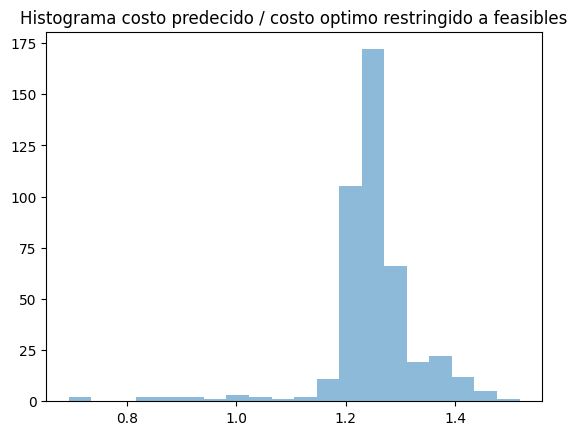

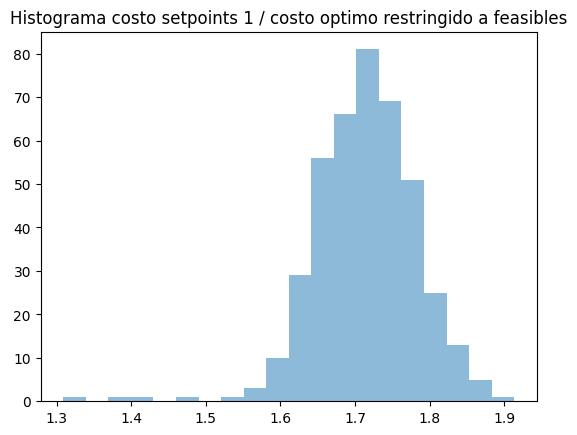

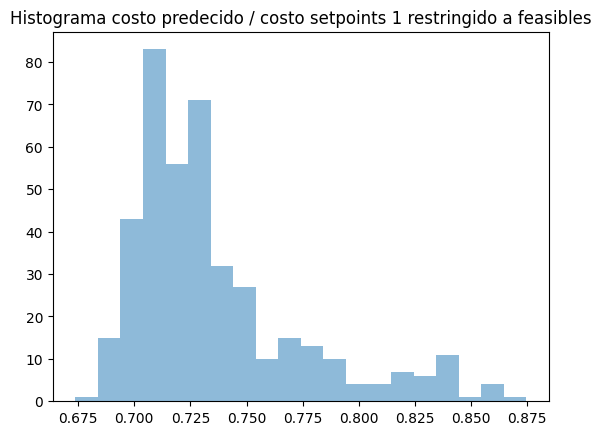

In [30]:
# FEASIBILITY

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo predecido / costo setpoints 1 restringido a feasibles")
plt.hist(v_cost_hist[(unf_hist[:,2] == 0) * (unf_hist[:,0] == 0),0] / v_cost_hist[(unf_hist[:,2] == 0) * (unf_hist[:,0] == 0),2], bins=20, alpha=0.5, label='pred/v1')
plt.show()